 ### Vision
The vision module handles everything related to the camera. There are four classes : *vision, robot, obstacle* and *target*.
The class Vision is the main class and contains a robot, obstacle and target element.

The vision is mainly based on color differentiation. The following part will demonstrate the whole process


We will use a picture as an example of what the camera could see.
![Example image](demo_img/vision_demo.png)

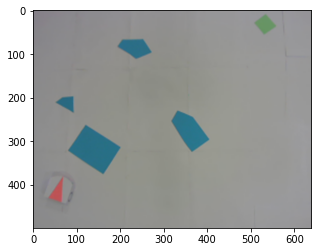

In [4]:
import sys as _sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
from copy import deepcopy

_sys.path.append("./src")
actual_frame = cv2.imread("demo_img/vision_demo.png", cv2.IMREAD_COLOR)
actual_frame = cv2.cvtColor(actual_frame, cv2.COLOR_BGR2RGB)
plt.imshow(actual_frame)

Each color has to be set individually. To do this, we decided to use the Color Picker from ipywidget. As this is a demo, the colors has already been picked

In [5]:
robot_color = np.array([189, 84, 83])
target_color = np.array([103, 148, 100])
obstacles_color = np.array([ 42, 115, 139])

We also have to choose the threshold for each color. The better the uniformity of the color, the lower the thresholds needs to be. As the colors are very uniform, we can use low thresholds.

In [6]:
targetthresh = 20
robotthresh = 20
obstaclesthresh = 20

#### Robot detection
In order to detect the red triangle on top the robot, we first compare the actual frame with the supposed color of the robot

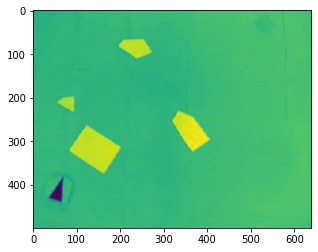

In [7]:
compare_color = abs(actual_frame - robot_color)
compare_gray = np.mean(compare_color, axis=2)
plt.imshow(compare_gray)

From this, we get a binary image, using the threshold set before

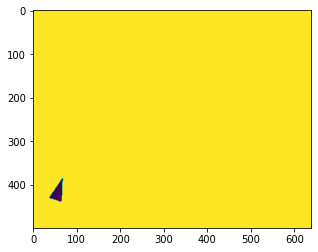

In [8]:
_, binary_img = cv2.threshold(compare_gray, robotthresh, 10, cv2.THRESH_BINARY)
plt.imshow(binary_img)

Now, we can use cv2.findContours and cv2.approxPolyDP in order to get the triangular shape. We check that the area is big enough and that the shape is actually a triangle.

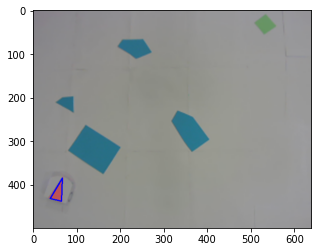

In [9]:
robot_contour, _ = cv2.findContours(binary_img.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
robot_contour = cv2.approxPolyDP(robot_contour[1], 0.03 * cv2.arcLength(robot_contour[1], True), True).reshape(-1,2)
area = cv2.contourArea(robot_contour)
assert(40 < area <  actual_frame.shape[0] * actual_frame.shape[1])
assert(robot_contour.shape[0] == 3)

# Show the results
plt.imshow(cv2.drawContours(actual_frame.copy(), [robot_contour], 0, (0,0,255), 2))

From there, we can find the center of the robot, its orientation using the bisector, and the coefficient pixel / cm, knowing the real length of an edge of the triangle.

the coef mm to px is :  0.4757244997074759


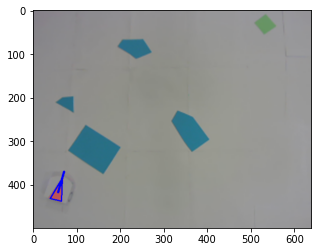

In [10]:
center = np.zeros(2)
M = cv2.moments(robot_contour)
center[0] = int(M['m10'] / M['m00'])
center[1] = int(M['m01'] / M['m00'])

LENGTH_EDGE = 115

dist = np.zeros(3)
dist[0] = np.linalg.norm(robot_contour[2] - robot_contour[1])
dist[1] = np.linalg.norm(robot_contour[0] - robot_contour[2])
dist[2] = np.linalg.norm(robot_contour[0] - robot_contour[1])
max_id = np.argmin(dist)
orientation = np.arctan2(robot_contour[max_id, 1] - center[1], robot_contour[max_id, 0] -  center[0])
mm2px = max(dist) / LENGTH_EDGE
_, robot_length = cv2.minEnclosingCircle(robot_contour)
print("the coef mm to px is : ", mm2px)

# Show the results
contour_img = cv2.drawContours(actual_frame.copy(), [robot_contour], 0, (0,0,255), 2)
point = (center + np.array([np.cos(orientation) * 50, np.sin(orientation) * 50])).astype(int)
contour_orientation_img = cv2.line(contour_img, center.astype(int), point, (0, 0, 255), thickness=3, lineType=8)
plt.imshow(contour_orientation_img)

#### Obstacles
The same can be done to find the contours of the obstacles.

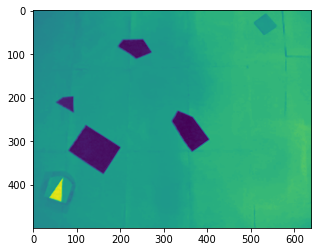

In [11]:
compare_color = abs(actual_frame - obstacles_color)
compare_gray = np.mean(compare_color, axis=2)
plt.imshow(compare_gray)

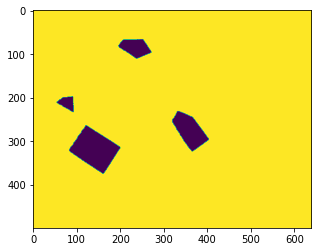

In [12]:
_, binary_img = cv2.threshold(compare_gray, obstaclesthresh, 10, cv2.THRESH_BINARY)
plt.imshow(binary_img)

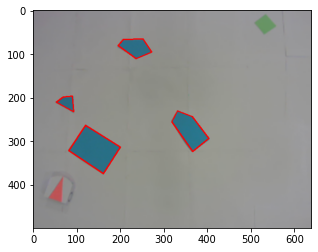

In [13]:
def polygon_detection(binary_img):
    contours, _ = cv2.findContours(binary_img.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    approx_cnt = []

    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.03 * cv2.arcLength(cnt, True), True)
        area = cv2.contourArea(approx)
        if 40 < area < 0.8 * actual_frame.shape[0] * actual_frame.shape[1]:
            approx_cnt.append(approx.reshape(-1, 2))

    return approx_cnt

obstacle_contours = polygon_detection(binary_img)
# Show the results
img_mask = actual_frame.copy()
for cnt in obstacle_contours:
    cv2.drawContours(img_mask, [cnt], 0, (255, 0, 0), 2)

plt.imshow(img_mask)

We need to expand the contours to get the points where the Thymio could fit.

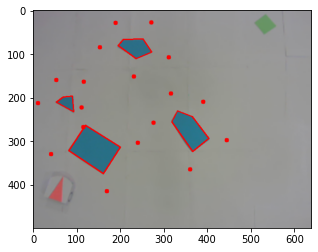

In [14]:
expanded_obstacle_contours = deepcopy(obstacle_contours)
for i, cnt in enumerate(obstacle_contours):
    for j, corner in enumerate(cnt):
        e1 = cnt[(j - 1) % cnt.shape[0]] - corner
        e2 = cnt[(j + 1) % cnt.shape[0]] - corner
        bisector = (e1 / np.linalg.norm(e1) + e2 / np.linalg.norm(e2))
        expanded_obstacle_contours[i][j] = corner - 1.5 * robot_length * bisector / np.linalg.norm(bisector)

# Show the results
extended_obstacles_img = actual_frame.copy()
for cnt in expanded_obstacle_contours:
    cnt = cnt.astype(int)
    for dot in cnt:
        img = cv2.circle(extended_obstacles_img, dot.flatten(), 5, (255, 0, 0), -1)

for cnt in obstacle_contours:
    cv2.drawContours(extended_obstacles_img, [cnt], 0, (255, 0, 0), 2)

plt.imshow(extended_obstacles_img)

Some contours are close enough to prevent the Thymio from going in between. We can merge them together.
To do so, we first draw the expanded obstacles then we detect the contour of the generated image

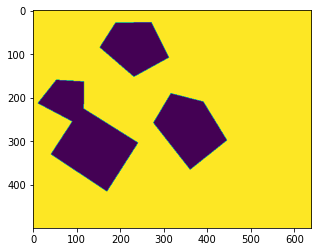

In [15]:
img = 255 * np.ones_like(actual_frame[:, :, 0])
for cnt in expanded_obstacle_contours:
    cv2.drawContours(img, [cnt], 0, 0, thickness=cv2.FILLED)
expanded_obstacle_contours = polygon_detection(img)
plt.imshow(img)

Some contours are not convex. We can make them convex using cv2.convexHull()

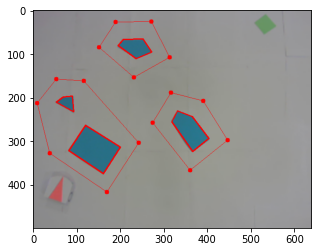

In [16]:
img = 255 * np.ones_like(actual_frame[:, :, 0])
for contour in expanded_obstacle_contours:
    cv2.drawContours(img, [cv2.convexHull(contour)], 0, 0, thickness=cv2.FILLED)
expanded_obstacle_contours_convex = polygon_detection(img)
# Show the results
extended_obstacles_img = actual_frame.copy()
for cnt in expanded_obstacle_contours_convex:
    cnt = cnt.astype(int)
    for dot in cnt:
        cv2.circle(extended_obstacles_img, dot.flatten(), 5, (255, 0, 0), -1)

for cnt in expanded_obstacle_contours_convex:
    cv2.drawContours(extended_obstacles_img, [cnt], 0, (255, 0, 0), 1)

for cnt in obstacle_contours:
    cv2.drawContours(extended_obstacles_img, [cnt], 0, (255, 0, 0), 2)

plt.imshow(extended_obstacles_img)

#### Target
We only need to find the center of the contour, using the same method as before

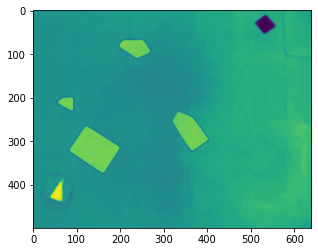

In [17]:
compare_color = abs(cv2.medianBlur(actual_frame, 9)
 - target_color)
compare_gray = np.mean(compare_color, axis=2)
plt.imshow(compare_gray)

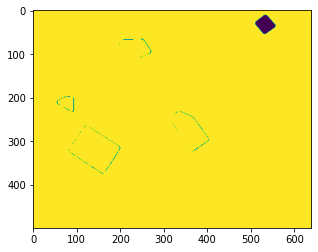

In [18]:
_, binary_img = cv2.threshold(compare_gray, targetthresh, 10, cv2.THRESH_BINARY)
plt.imshow(binary_img)

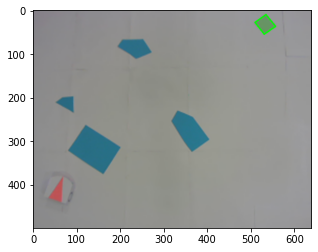

In [19]:
target_contour = polygon_detection(binary_img)[0]

# Show the results
plt.imshow(cv2.drawContours(actual_frame.copy(), [target_contour], 0, (0,255,0), 2))